In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.0 MB/s 
     |████████████████████████████████| 182 kB 69.2 MB/s 
     |████████████████████████████████| 7.6 MB 44.9 MB/s 


In [ ]:
!pip install keras-bert
!pip install keras-radam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33516 sha256=129badaa4f5bec01bf6652f98ccbca1d51a0020cfc5a4c2874e6c94c9a8cbeaa
  Stored in directory: /root/.cache/pip/wheels/a1/34/ed/6bbd71716d7bcea30d75e8bc5aeb94f4cb52636295c8343534
  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12304 sha256=6660fc48618dce56d962e0d6c53e8f5a3feac0fa17fa65543283ca472f5a9e9d
  Stored in directory: /root/.cache/pip/wheels/07/cd/a7/a8fa93f7e177eee0101fed63179f7a2fa3b53671ffaad82bfd
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.10.0-py3-none-any.whl size=3959 sha256=e551aa169b97501e16442173df9c705781c0accb3b373ad9dd6751ecc448a4ef
  Stored in directory: /root/.cache/pip/wheels/59/bd/9a/ec6e575aaa50687d7af968bde7ce710b542eeaa9ee7978d4ba
  Created wheel for keras-layer-normalization: filename=keras_layer_normalizatio

In [ ]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 5.0 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=cf84039a376129a8ba88129a5ad4b09bef2a8fbf642655b397e2118fa54f627e
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [ ]:
import tensorflow.keras as tf
import pandas as pd
import numpy as np  
import re
import pickle
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers

import codecs
from tqdm import tqdm
import shutil

In [ ]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from transformers import BertModel
from torch.optim import Adam
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 다운 bert 모형 불러옴
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam
import emoji

input : df['Utterance'] 문장이 들어감

output : 감정종류가 나옴

In [ ]:
# bert 이미 학습된 모델임
os.listdir('/content/drive/MyDrive/bert')

['vocab.txt',
 'bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.meta',
 'bert_model.ckpt.index',
 'bert1.h5']

In [ ]:
# bert 경로지정해줌
path = "/content/drive/MyDrive/bert"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 폴더를 복사하는 함수를 정의 Bert 모델은 GDrive 에 존재
# Colab 클라우드 컴퓨터 안에 Bert 모형을 직접 저장하면, GDRIVE 경유 하는 것보다 사전 학습된 모델을 로드하는 시간이 단축
def copytree(src, dst, symlinks = False, ignore = None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

In [ ]:
# Colab 클라우드 서버에 bert라는 폴더를 생성함
os.makedirs("bert")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/open/train.csv')

In [ ]:
x_train = df[['Utterance']]
# y_train = df['Target']인 경우에 시리즈로 나오기 때문에 df[[Target]]으로 하여 df 형태로 바꿔줌
y_train = df.iloc[:,-1]

In [ ]:
# SEQ_LEN : 문장의 최대 길이, 문장보다 길이가 작아지면 0이 채워지고, 문장이 길다면  초과하는 부분은 잘라냄
# BATCH_SIZE : 메모리 초과 같은 문제를 방지하기 위함 
# EPOCHS총 훈련 에포크 수 
# LR 학습률
# 하이퍼파라미터

# bert 모형의 사전모델
SEQ_LEN = 128 #한국어는 60 정도 들어감
BATCH_SIZE = 16 # 16보다 크면 메모리 오류가 일어나서 학습이 힘들다
EPOCHS = 4
LR = 1e-5

In [ ]:
path = ('/content/drive/MyDrive/bert')

pretrained_path = path
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "Utterance"
LABEL_COLUMN = "Target"

In [ ]:
# 몇 번째에 단어가 위치하는지 인덱싱을 구현함
# vocab.txt에 있는 단어에 인덱스를 추가해주는 token_dict 라는 딕셔너리 생성함
# 분석할 문장이 토큰화됨
# 그 다음 인덱스(숫자)로 변경되어서 버트 신경망에 인풋으로 들어감

#vocab.txt는 단어들에다가 인덱싱을 부여서 위치를 알 수 있게해줌
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [ ]:
# 문장을 tokenize
# 전처리 
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [ ]:
tokenizer = inherit_Tokenizer(token_dict)

In [ ]:
# 데이터를 버트 모형의 입력에 맞게 변형을 해줘야 함
# convert_data 함수 정의해줌
# pandas 데이터를 input 으로 받았음
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer .encode(data_df[DATA_COLUMN][i], max_len = SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x, data_y = convert_data(data_df)
    
    return data_x, data_y

In [ ]:
x_train, y_train =load_data(df)

  0%|          | 0/9989 [00:00<?, ?it/s]

In [ ]:
# LABEL ENCODING
from sklearn.preprocessing import LabelEncoder
model = LabelEncoder()
model.fit(y_train)
y_train = model.transform(y_train)
y_train

array([4, 4, 4, ..., 6, 4, 3])

In [ ]:
# 라벨인코딩된 순서 
model.classes_

array(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness',
       'surprise'], dtype='<U8')

In [ ]:
# 9989 문장개수
np.array(x_train).shape

In [ ]:
x_train1 = np.array(x_train)
x_train1[0] 
x_train1[1]
# x_train1 = x_train1.reshape(2,9989,128)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y_train.shape

In [ ]:
# x_train = df[['Utterance']]
# y_train = df.iloc[:,-1]
from sklearn.model_selection import train_test_split

In [ ]:
# 사실상 y_train은 한 번만 나눈 것임
X_train_token, X_test_token, Y_train, Y_test = train_test_split(x_train1[0], y_train, random_state = 42, test_size = 0.2)
# y_train을 나누지만 따로 변수를 설정하지는 않음
X_train_seg, X_test_seg, _, _ = train_test_split(x_train1[1], y_train, random_state = 42, test_size = 0.2)
# X_train_seg, X_test_seg, Y_train, Y_test = train_test_split(x_train1[1], y_train, random_state = 42, test_size = 0.2)
X_train = np.array([X_train_token, X_train_seg]) #8000
X_test = np.array([X_test_token, X_test_seg]) # 2000

In [ ]:
print(X_train[0].shape)
print(X_train[1].shape)

In [ ]:
# ERROR Found input variables with inconsistent numbers of samples: [7991, 6392] 변수명
Y_train0 = Y_train

In [ ]:
# Y_train[6392] , Y_train [7991]
# Y_train[] , Y_train[6392]
X_train_token, X_val_token, Y_train, Y_val = train_test_split(X_train[0], Y_train0, random_state = 42, test_size = 0.2)
X_train_seg, X_val_seg, Y_train, Y_val = train_test_split(X_train[1], Y_train0, random_state = 42, test_size = 0.2)

X_train = np.array([X_train_token, X_train_seg ])
X_val = np.array([X_val_token, X_val_seg])

In [ ]:
X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

In [ ]:
model.classes_

In [ ]:
import emoji
emoji_map = {
     4 : ("\U0001F611", "\U0001F610","\U0001F636","\U0001F644"),
     6 : ("\U0001F632", "\U0001F633","\U0001F440", "\U0001F648 "),
      2 : ("\U0001F631", "\U0001F628","\U0001F627", "\U0001F92F"),
      5 : ("\U0001F622", "\U0001F62D", "\U0001F63F", '\U0001F625'),
      3 : ("\U0001F601", "\U0001F970", "\U0001F603", "\U0001F606"),
      1 : ("\U0001F922", "\U0001F635", "\U0001F623","\U0001F635"),
      0 : ("\U0001F621", "\U0001F47F", "\U0001F624","\U0001F620")
}
def label_to_emoji(label):
    return print(emoji_map[label])

In [ ]:
print(emoji_map[0])
print(emoji_map[1])
print(emoji_map[2])
print(emoji_map[3])
print(emoji_map[4])
print(emoji_map[5])
print(emoji_map[6])

('😡', '👿', '😤', '😠')
('🤢', '😵', '😣', '😵')
('😱', '😨', '😧', '🤯')
('😁', '🥰', '😃', '😆')
('😑', '😐', '😶', '🙄')
('😢', '😭', '😿', '😥')
('😲', '😳', '👀', '🙈 ')


In [ ]:
# 바로 문장을 받아서 토큰화 해주고 토큰에 인덱스도 해주고 세그먼트도 해줌
def sentence_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len = SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

# sentence는 List로 받는다
def sentence_load_data(sentences):
    data_x = sentence_convert_data(sentences)
    return data_x

In [ ]:
# 사전학습된 모델,  bert 모델을 불러옴
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training = True,
    trainable = True,
    seq_len = SEQ_LEN,
)

In [ ]:
model.summary()

In [ ]:
def get_bert_finetuning_model(model):
    inputs = model.inputs[:2]
    dense = model.layers[-3].output
    outputs = keras.layers.Dense(7, activation ='softmax', kernel_initializer = keras.initializers.TruncatedNormal(stddev=0.02))(dense)
    bert_model = keras.models.Model(inputs, outputs)
    bert_model.compile(
        optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.00001, weight_decay = 0.0025),
        loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']
    )
    return bert_model

In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 17.6 MB/s 


In [ ]:
import tensorflow_addons as tfa
tfa.optimizers.RectifiedAdam()

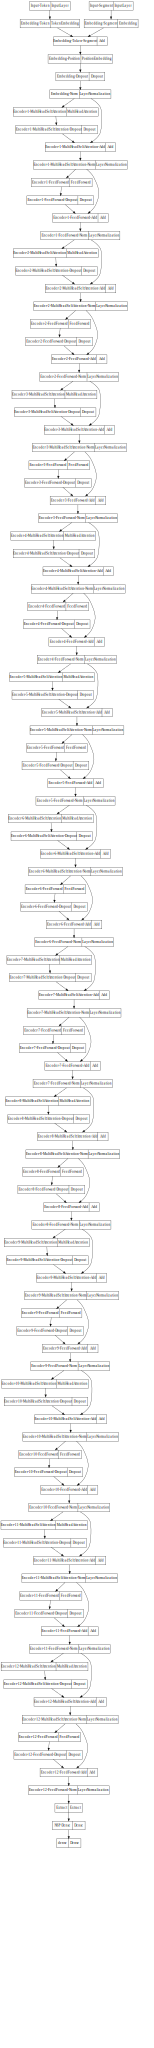

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

In [ ]:
bert = get_bert_finetuning_model(model)
bert.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 Input-Segment (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 Embedding-Token (TokenEmbeddin  [(None, 128, 768),  91812096    ['Input-Token[0][0]']            
 g)                              (119547, 768)]                                                   
                                                                                                  
 Embedding-Segment (Embedding)  (None, 128, 768)     1536        ['Input-Segment[0][0]']    

In [ ]:
import tensorflow
import keras.backend as K
K.clear_session()
import tensorflow.keras.backend as K
from tensorflow.python.keras.backend import get_session

In [ ]:
tf.compat.v1.keras.backend.set_session(session)
tf.compat.v1.keras.backend.set_session()
K.set_session
tf.compat.v1.Session()

In [ ]:
tf.__version__

In [ ]:
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
with tensorflow.compat.v1.Session() as sess:
    uninitialized_variables = set([i.decode('ascii') for i in sess.run(tensorflow.compat.v1.report_uninitialized_variables())])
    init = tensorflow.compat.v1.variables_initializer([v for v in tensorflow.compat.v1.global_variables() if v.name.split(':')[0] in uninitialized_variables])
    sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(X_train, Y_train, epochs = 10, batch_size = 16, verbose = 1, shuffle=False, validation_data = (X_val, Y_val))
bert_model.save_weights(path + "/bert1.h5")

Epoch 1/10
400/400 [==============================] - 275s 580ms/step - loss: 1.4955 - accuracy: 0.4851 - val_loss: 1.3341 - val_accuracy: 0.5391
Epoch 2/10
400/400 [==============================] - 227s 569ms/step - loss: 1.2472 - accuracy: 0.5887 - val_loss: 1.2229 - val_accuracy: 0.5922
Epoch 3/10
400/400 [==============================] - 227s 568ms/step - loss: 1.1326 - accuracy: 0.6339 - val_loss: 1.2156 - val_accuracy: 0.5979
Epoch 4/10
400/400 [==============================] - 227s 568ms/step - loss: 1.0203 - accuracy: 0.6738 - val_loss: 1.2349 - val_accuracy: 0.6041
Epoch 5/10
400/400 [==============================] - 227s 568ms/step - loss: 0.8999 - accuracy: 0.7128 - val_loss: 1.3117 - val_accuracy: 0.5897
Epoch 6/10
400/400 [==============================] - 227s 568ms/step - loss: 0.7622 - accuracy: 0.7642 - val_loss: 1.3765 - val_accuracy: 0.5641
Epoch 7/10
400/400 [==============================] - 227s 567ms/step - loss: 0.6314 - accuracy: 0.8066 - val_loss: 1.4857 -

In [ ]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    ids, segments = tokenizer.encode(data, max_len=SEQ_LEN)
    indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

In [ ]:
def emoji_prediction(sentence):
    data_x = sentence_convert_data(sentence)
    predict = bert_model.predict(data_x)
    # predict_answer = np.round(predict.flatten(), 0).item()
    # argmax 제일 높은 확률값을 가져다줌
    predict_index = np.argmax(predict, axis =1)[0]
    # return label_to_emoji([int(i) for i in predict_index])
    # return [int(i) for i in predict_index]
    return predict_index

    print(predict)
    # print([int(i) for i in predict])

In [ ]:
label_to_emoji(emoji_prediction("I love you"))

1/1 [==============================] - 0s 41ms/step
('😁', '🥰', '😃', '😆')


In [ ]:
label_to_emoji(emoji_prediction("I hate you"))

1/1 [==============================] - 0s 44ms/step
('🤢', '😵', '😣', '😵')


In [ ]:
label_to_emoji(emoji_prediction("I'm so blue"))

1/1 [==============================] - 0s 195ms/step
('😑', '😐', '😶', '🙄')


In [ ]:
label_to_emoji(emoji_prediction("I'm so sad"))

1/1 [==============================] - 0s 42ms/step
('😑', '😐', '😶', '🙄')


In [ ]:
label_to_emoji(emoji_prediction("scared"))

1/1 [==============================] - 0s 43ms/step
('😡', '👿', '😤', '😠')


In [ ]:
label_to_emoji(emoji_prediction("happy"))

1/1 [==============================] - 0s 53ms/step
('😁', '🥰', '😃', '😆')


In [ ]:
label_to_emoji(emoji_prediction("disgusted"))

1/1 [==============================] - 0s 56ms/step
('😢', '😭', '😿', '😥')


In [ ]:
label_to_emoji(emoji_prediction("hurt"))

1/1 [==============================] - 0s 40ms/step
('😡', '👿', '😤', '😠')
